## 두 넘파이 배열에 대해 코사인 유사도를 구하는 함수 생성

In [9]:
import numpy as np

def cos_similarity(v1,v2):
    dot_product = np.dot(v1,v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm
    
    return similarity

## 3개의 간단한 문서의 유사도 비교

3개의 간단한 문서를 TF-IDF로 벡터화된 행렬로 변환

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends',
           'if you take the red pill, you stay in Wonderland',
           'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


## 문장 1,2의 유사도 비교

In [11]:
#TFidfVectorizer로 transform()한 결과는 희소 행렬이므로 밀집 행렬로 변환
feature_vect_dense = feature_vect_simple.todense()

#첫 번째 문장과 두 번째 문장의 피처 벡터 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1, )
vect2 = np.array(feature_vect_dense[1]).reshape(-1, )

#첫 번째 문장과 두 번째 문장의 피처 벡터로 두 개 문장의 코사인 유사도 추출
similarity_simple = cos_similarity(vect1,vect2)
print('문장 1,2의 Cosine 유사도 : {0:.3f}'.format(similarity_simple))

문장 1,2의 Cosine 유사도 : 0.402


## 문장 1,3의 유사도 비교

In [12]:
vect3 = np.array(feature_vect_dense[2]).reshape(-1, )
similarity_simple = cos_similarity(vect1,vect3)
print('문장 1,3의 Cosine 유사도 : {0:.3f}'.format(similarity_simple))

문장 1,3의 Cosine 유사도 : 0.404


## 문장 2,3의 유사도 비교

In [13]:
similarity_simple = cos_similarity(vect2,vect3)
print('문장 2,3의 Cosine 유사도 : {0:.3f}'.format(similarity_simple))

문장 2,3의 Cosine 유사도 : 0.456


## sklearn의 API를 이용하여 문서 유사도 비교

In [14]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0],feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [16]:
# 1은 자기자신과의 유사도
#1을 없애는 코드 

similarity_simple_pair = cosine_similarity(feature_vect_simple[0],feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [17]:
similarity_simple_pair = cosine_similarity(feature_vect_simple, feature_vect_simple)
print(similarity_simple_pair)
print('similarity_simple_pair shape : ',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
similarity_simple_pair shape :  (3, 3)


## Opinion Review 데이터 셋을 이용한 문서 유사도 측정

In [30]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [34]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = r'C:\Users\suhye\Desktop\Kaggle\OpinosisDataset1.0\OpinosisDataset1.0\topics'
all_files = glob.glob(os.path.join(path, "*.data"))     
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = file_.split('\\')[-1]
    filename = filename_.split('.')[0]
    filename_list.append(filename)
    opinion_text.append(df.to_string())

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

C:\Users\suhye\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


## 호텔을 주제로 군집화된 문서와 다른 문서와의 유사도 측정

호텔을 주제로 군집화된 문서의 인덱스 추출 -> TfidfVectorizer 객체 변수인 feature_vect에서 호텔로 군집화된 문서의 피처벡터 추출

In [36]:
from sklearn.metrics.pairwise import cosine_similarity

#호텔로 군집화된 문서의 인덱스 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print("호텔로 군집화된 문서의 DataFrame Index : ",hotel_indexes)

#그중 첫 번째 문서 추출해 파일명 표시
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('비교 문서명',comparison_docname, '와 타 문서 유사도')

#document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 군집화된 feature_vect 추출
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]], feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 군집화된 문서의 DataFrame Index :  Int64Index([6, 7, 16, 17, 18, 22, 25, 29, 37, 47], dtype='int64')
비교 문서명 comfort_honda_accord_2008 와 타 문서 유사도
[[1.         0.83969704 0.15655631 0.33044002 0.25981841 0.16544257
  0.27569738 0.18050974 0.65502034 0.06229873]]


첫 번째 문서와 다른 문서간의 유사도가 높은 순 정렬 후 시각화

Text(0.5, 1.0, 'comfort_honda_accord_2008')

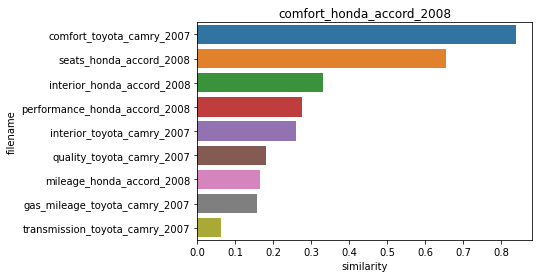

In [39]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#첫 번째 문서와 타 문서 간 유사도가 큰 순으로 정렬한 인덱스를 추출하되 자기 자신 제외
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:,1:]

#유사도가 큰 순으로 hotel_indexes 추출해 재정렬
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

#유사도가 큰 순으로 유사도 값 재정렬 하되 자기 자신 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

#유사도가 큰 순으로 정렬된 인덱스와 유사도 값을 이용해 파일명과 유사도 값을 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity',y='filename',data = hotel_1_sim_df)
plt.title(comparison_docname)